

# Multiple Output Models using the Keras Functional API

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

import utils

In [3]:
# URL of the white wine dataset
URI = './winequality-white.csv'

# # load the dataset from the URL
white_df = pd.read_csv(URI, sep=";")

# fill the `is_red` column with zeros.
white_df["is_red"] = 0

# keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')


In [6]:
# URL of the red wine dataset
URI = './winequality-red.csv'

# load the dataset from the URL
red_df = pd.read_csv(URI, sep=";")

# fill the `is_red` column with ones.
red_df["is_red"] = 1

# keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')


In [9]:
df = pd.concat([red_df, white_df], ignore_index=True)

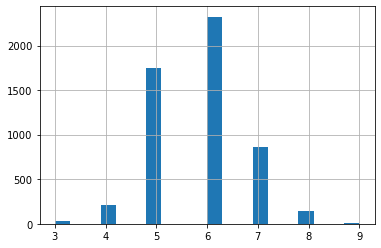

In [11]:
df['quality'].hist(bins=20);

In [12]:
# get data with wine quality greater than 4 and less than 8
df = df[(df['quality'] > 4) & (df['quality'] < 8 )]

# reset index and drop the old one
df = df.reset_index(drop=True)

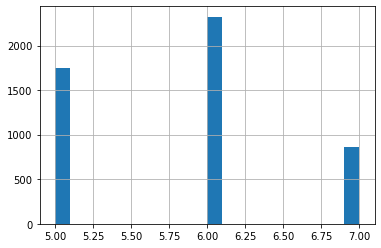

In [15]:
df['quality'].hist(bins=20);

In [16]:
# split df into 80:20 train and test sets
train, test = train_test_split(df, test_size=0.2, random_state = 1)
                               
# split train into 80:20 train and val sets
train, val = train_test_split(train, test_size=0.2, random_state = 1)

In [18]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

In [19]:
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.221616,1.325297,3.80000,6.40000,7.00000,7.7000,15.60000
volatile acidity,3155.0,0.338929,0.162476,0.08000,0.23000,0.29000,0.4000,1.24000
citric acid,3155.0,0.321569,0.147970,0.00000,0.25000,0.31000,0.4000,1.66000
residual sugar,3155.0,5.155911,4.639632,0.60000,1.80000,2.80000,7.6500,65.80000
chlorides,3155.0,0.056976,0.036802,0.01200,0.03800,0.04700,0.0660,0.61100
free sulfur dioxide,3155.0,30.388590,17.236784,1.00000,17.00000,28.00000,41.0000,131.00000
total sulfur dioxide,3155.0,115.062282,56.706617,6.00000,75.00000,117.00000,156.0000,344.00000
density,3155.0,0.994633,0.003005,0.98711,0.99232,0.99481,0.9968,1.03898
pH,3155.0,3.223201,0.161272,2.72000,3.11000,3.21000,3.3300,4.01000
sulphates,3155.0,0.534051,0.149149,0.22000,0.43000,0.51000,0.6000,1.95000


In [20]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [21]:
# format the output of the train set
train_Y = format_output(train)

# format the output of the val set
val_Y = format_output(val)
    
# # format the output of the test set
test_Y = format_output(test)

In [23]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,7.5,0.65,0.18,7.0,0.088,27.0,94.0,0.99915,3.38,0.77,9.4
3557,6.3,0.27,0.29,12.2,0.044,59.0,196.0,0.99782,3.14,0.40,8.8
3825,8.8,0.27,0.25,5.0,0.024,52.0,99.0,0.99250,2.87,0.49,11.4
1740,6.4,0.45,0.07,1.1,0.030,10.0,131.0,0.99050,2.97,0.28,10.8
1221,7.2,0.53,0.13,2.0,0.058,18.0,22.0,0.99573,3.21,0.68,9.9


In [26]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [27]:
# normalize the train set
norm_train_X = norm(train)
    
# normalize the val set
norm_val_X = norm(val)
    
# normalize the test set
norm_test_X = norm(test)

In [29]:
def base_model(inputs):
    
    # Connect a Dense layer with 128 neurons and a relu activation
    x = Dense(128, activation='relu')(inputs)
    
    # Connect another Dense layer with 128 neurons and a relu activation
    x = Dense(128, activation='relu')(x)
    
    return x

  

In [31]:
def final_model(inputs):
    
    # Get the base model
    x = base_model(inputs)

    # Connect the output Dense layer for regression
    wine_quality = Dense(units=1, name='wine_quality')(x)

    # Connect the output Dense layer for classification. This will use a sigmoid activation.
    wine_type = Dense(units=1, activation='sigmoid', name='wine_type')(x)

    # Define the model using the input and output layers
    model = Model(inputs=inputs, outputs=[wine_quality, wine_type])

    return model


In [38]:
inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(lr=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms, 
              loss={'wine_type': 'binary_crossentropy',
                    'wine_quality': 'mean_squared_error'
                   },
              metrics={'wine_type': 'accuracy',
                       'wine_quality': tf.keras.metrics.RootMeanSquaredError()
                     }
             )


In [40]:
history = model.fit(norm_train_X, train_Y,
                    epochs=40, validation_data=(norm_val_X, val_Y))

Train on 3155 samples, validate on 789 samples
Epoch 1/40
3155/3155 [==============================] - 1s 403us/sample - loss: 27.7421 - wine_quality_loss: 26.9756 - wine_type_loss: 0.7341 - wine_quality_root_mean_squared_error: 5.1969 - wine_type_accuracy: 0.3239 - val_loss: 19.5075 - val_wine_quality_loss: 18.8050 - val_wine_type_loss: 0.7142 - val_wine_quality_root_mean_squared_error: 4.3351 - val_wine_type_accuracy: 0.5120
Epoch 2/40
3155/3155 [==============================] - 0s 140us/sample - loss: 13.2503 - wine_quality_loss: 12.5308 - wine_type_loss: 0.6918 - wine_quality_root_mean_squared_error: 3.5438 - wine_type_accuracy: 0.6377 - val_loss: 7.8420 - val_wine_quality_loss: 7.2220 - val_wine_type_loss: 0.6640 - val_wine_quality_root_mean_squared_error: 2.6792 - val_wine_type_accuracy: 0.7186
Epoch 3/40
3155/3155 [==============================] - 0s 128us/sample - loss: 5.4056 - wine_quality_loss: 4.7768 - wine_type_loss: 0.6189 - wine_quality_root_mean_squared_error: 2.1878 

In [42]:
# Gather the training metrics
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')



789/789 [==============================] - 0s 25us/sample - loss: 0.3688 - wine_quality_loss: 0.3357 - wine_type_loss: 0.0321 - wine_quality_root_mean_squared_error: 0.5799 - wine_type_accuracy: 0.9924

loss: 0.36881963657486727
wine_quality_loss: 0.3356698751449585
wine_type_loss: 0.032102227210998535
wine_quality_rmse: 0.5799434185028076
wine_type_accuracy: 0.9923954606056213


In [43]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

In [46]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


In [47]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(test_Y[1], np.round(type_pred), labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0, 1])
    disp.plot(values_format='d');

In [48]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

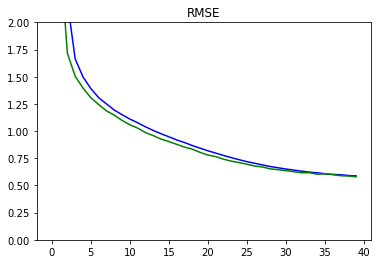

In [49]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

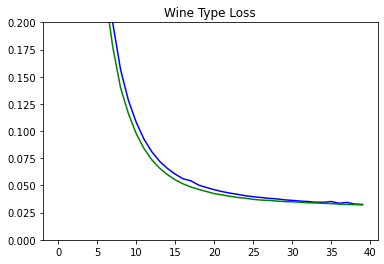

In [50]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

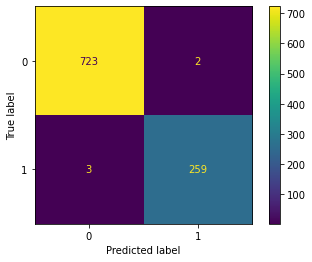

In [51]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

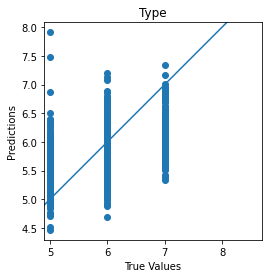

In [52]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')